# Compare w/ JPL Horizons

In the generate particle ephemeris tutorial, we demonstrated how to integrate the motion of a particle and check its position on-sky. Here we'll check how those results compare to those taken straight from JPL Horizons.

First, let's take a look at the same object we looked at in the previous tutorial, (274301) Wikipedia.

In [20]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import warnings

warnings.filterwarnings("ignore", module="erfa")

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time
from astropy.coordinates import SkyCoord
from tqdm import tqdm

from jorbit.utils.horizons import horizons_bulk_astrometry_query
from jorbit import Particle

First, we'll use jorbit to create an ephemeris spanning a decade. It will start by asking Horizons for the state of the particle at the first time, but after that, its motion is integrated fully locally.

In [ ]:
times = Time("2025-01-01") + jnp.arange(0, 365 * 10, 10) * u.day

p = Particle.from_horizons(name="274301", time=Time("2025-01-01"))
jorbit_eph = p.ephemeris(times=times, observer="kitt peak")

Next, we'll ask Horizons for the ephemeris of the same object over the same time span. Instead of using Astroquery or the web interface, we'll use a convenience function within jorbit for our Horizons API query. This is slightly more flexible than Astroquery and allows for bulk requests of possibly unevenly-spaced times.

In [10]:
data = horizons_bulk_astrometry_query(target="274301", center="695@399", times=times)
horizons_eph = SkyCoord(
    ra=data["RA"], dec=data["DEC"], unit=(u.deg, u.deg), obstime=times
)

Now we compare:

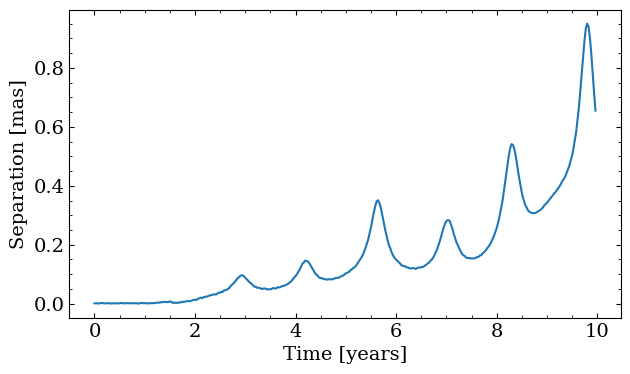

In [16]:
fig, ax = plt.subplots()
ax.plot((jnp.arange(0, 365 * 10, 10) * u.day).to(u.year), 
    (jorbit_eph.separation(horizons_eph)).to(u.mas)
)
ax.set(xlabel="Time [years]", ylabel="Separation [mas]");

For this particle at least, the agreement between jorbit and Horizons is well under 1 mas for most of a decade.

For a not strictly scientific (but hopefully qualitatively assuring) test, we can repeat this whole procedure for a handful of other objects. We'll select them by randomly drawing numbered objects according to their IDs:

In [25]:
np.random.seed(42)
particle_ids = np.random.randint(0, 700_000, size=50)

times = Time("2025-01-01") + jnp.arange(0, 365 * 10, 10) * u.day

seps = np.zeros((len(particle_ids), len(times)))
for i, p_id in tqdm(enumerate(particle_ids)):
    p = Particle.from_horizons(name=str(p_id), time=Time("2025-01-01"))
    jorbit_eph = p.ephemeris(times=times, observer="kitt peak")

    data = horizons_bulk_astrometry_query(
        target=str(p_id), center="695@399", times=times
    )
    horizons_eph = SkyCoord(
        ra=data["RA"], dec=data["DEC"], unit=(u.deg, u.deg), obstime=times
    )
    separation = jorbit_eph.separation(horizons_eph)
    seps[i] = separation.to(u.mas).value

50it [09:08, 10.98s/it]


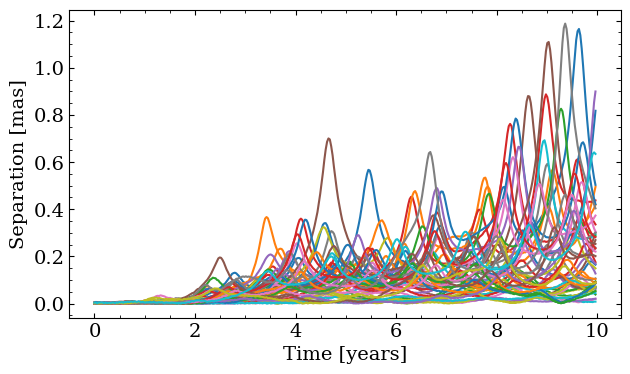

In [26]:
fig, ax = plt.subplots()
ax.plot((jnp.arange(0, 365 * 10, 10) * u.day).to(u.year), 
    seps.T
)
ax.set(xlabel="Time [years]", ylabel="Separation [mas]");

Thankfully it looks like (274301) Wikipedia wasn't just a lucky guess and that most of these objects are also in good agreement with Horizons. As a rule of thumb, within a ~year or so the agreement is usually within 0.1 mas, and within a decade it's usually within 1 mas.